# **Load Data**

**The goal of this project is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.**

In [ ]:
# !pip install opendatasets

In [ ]:
# import opendatasets as od
# url = "https://www.kaggle.com/c/quora-question-pairs/data"
# od.download(url)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/kaggle/input/quora-question-pairs/train.csv.zip")


# **EDA**

In [ ]:
# Structure of data
df.shape

(404290, 6)

In [ ]:
# Duplicate questions data
df[df["id"] == 244500]

,id,qid1,qid2,question1,question2,is_duplicate
244500,244500,24118,13778,What do you think of the Government's move of ...,What do you think will be the effect of Modi G...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
# Null value in datset
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
# Duplicate value in dataset
df.duplicated().sum()

0

In [ ]:
# Distribution of Duplicate and Non-duplicate questions
df["is_duplicate"].value_counts()

is_duplicate
0    255027
1    149263
Name: count, dtype: int64

In [ ]:
# Percentage Distribution of Duplicate and Non-duplicate questions
df["is_duplicate"].value_counts() / df["is_duplicate"].count() *100

is_duplicate
0    63.080215
1    36.919785
Name: count, dtype: float64

<Axes: ylabel='count'>

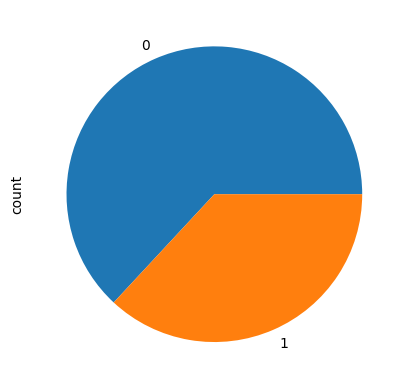

In [ ]:
df["is_duplicate"].value_counts().plot(kind = "pie")

In [ ]:
# repeated question
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 537933
Number of questions getting repeated 111780


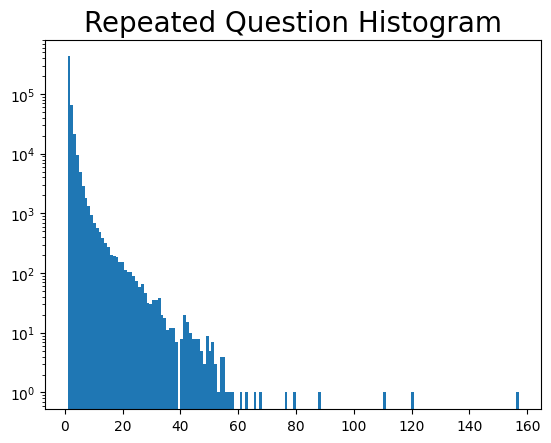

In [ ]:
# repeated question histograme
plt.hist(qid.value_counts() , bins = 160)
plt.yscale("log")
plt.title("Repeated Question Histogram" , size = 20)
plt.show()

Summary -

- As per our histogram unique question are in our datset are `10^5 ~ 5 lakhs`
- There is one question in our dataseyt which is repeated `120` times
- If we carryfully look at graph,Seems like there is one question which is almost repeated `~156 times`
- Most of the question in our datset are repeated approx 20 or 60 times

# **TF-IDF**

**TF-IDF (Term Frequency–Inverse Document Frequency) is a statistical method used in natural language processing and information retrieval to evaluate how important a word is to a document in relation to a larger collection of documents. TF-IDF combines two components:**

1. Term Frequency (TF): Measures how often a word appears in a document. A higher frequency suggests greater importance. If a term appears frequently in a document, it is likely relevant to the document’s content

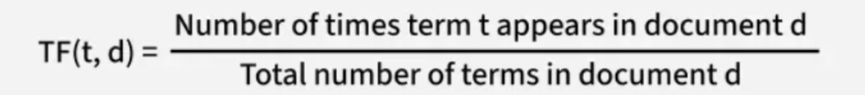


3. Inverse Document Frequency (IDF): Reduces the weight of common words across multiple documents while increasing the weight of rare words. If a term appears in fewer documents, it is more likely to be meaningful and specific.

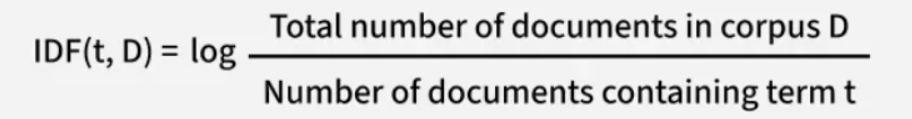


**Now let's understand with few example how TF IDF works?**

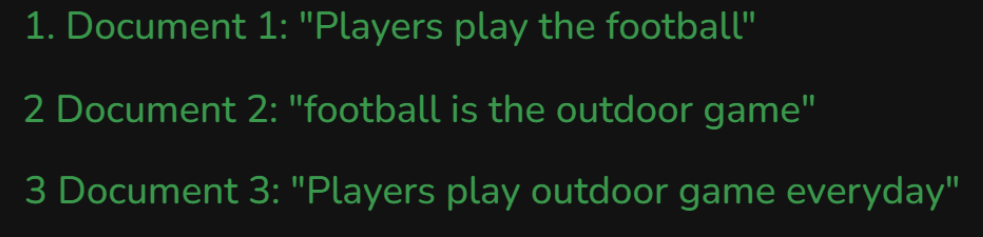

**Our goal is to calculate the TF-IDF score for specific terms in these documents. Let’s focus on the word "football" and see how TF-IDF evaluates its importance**

**Step 1 : Calculate Term Ferquency(TF)**

**For Document 1:**

 - The word "football" appear 1 time
 - The total number of terms in Document 1 is 4 ("Players" , "play" , "the" , "football")
 - so Now TF of football would be : TF(football , Document1) = 1 / 4

**For Document 2:**

 - The word "football" appear 1 time
 - The total number of terms in Document 2 is 5 ("football" , "is" , "the" , "outdoor" , "game")
 - so Now TF of football would be : TF(football , Document2) = 1 / 5

   
**For Document 3:**

 - The word "football" appear 0 time
 - The total number of terms in Document 1 is 5 ("Players" , "play" , "outdoor" , "game" ,"everyday")
 - so Now TF of football would be : TF(football , Document3) = 0

**Step 2 : Calculate Inverse Document Frequency (IDF))**


 - Total Number of Documents in the corpus (D) : 3
 - Number of documents containing the term "football" : 2 (Document 1 , Documnet 2)
 - IDF(football , D) = log 3/2  = 0.176
   


The TF-IDF score is the product of TF and IDF:

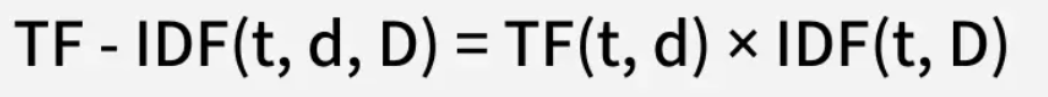

 - For Document 1: TF-IDF (football, Document 1, D): 0.25 * 0.176 = 0.044
 - For Document 2: TF-IDF(football, Document 2, D): 0.2x 0.176 = 0.0352
 - For Document 3: TF-IDF (football, Document 3, D): 0 x 0.176 = 0

In [ ]:
df.shape

(404290, 6)

In [ ]:
# consider only 10000 samples of data
new_df = df.sample(10000)

In [ ]:
ques_df = new_df[["question1" , "question2"]]
ques_df.head()

,question1,question2
284201,I never get satisfied with my decisions. What ...,Are we all time travelers?
234861,What is your best memory of a stranger?,What's your best memories that happened with a...
3887,What is document cryptography?,What is cryptography?
375363,Does anyone know of any good barbershop websit...,Barbershops: Are barber shops profitable?
199335,What are bad habits?,What are really bad habits?


In [ ]:
question = list(ques_df["question1"]) + list(ques_df["question2"])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    analyzer = "word" ,
    stop_words = ("english") ,
    ngram_range = (2,2) ,
    max_features = 3000,
    binary = True

)

In [ ]:
q1_arr  , q2_arr = np.vsplit(tfidf.fit_transform(question).toarray() , 2)

In [ ]:
print(tfidf.get_feature_names_out())
print(tfidf.idf_)

['000 views' '10 000' '10 best' ... 'youtube video' 'youtube videos'
 'yr old']
[9.29409964 9.11177808 9.29409964 ... 8.4186309  8.70631297 9.51724319]


In [ ]:
tfidf.vocabulary_

{'does know': 785,
 'bad habits': 175,
 'look like': 1648,
 'time travel': 2648,
 'int printf': 1427,
 'printf output': 2136,
 'output statement': 1982,
 'long does': 1643,
 'long time': 1646,
 'use everyday': 2732,
 'significance battle': 2380,
 'battle somme': 196,
 'somme did': 2431,
 'did battle': 693,
 'battle compare': 195,
 'compare contrast': 569,
 'contrast battle': 586,
 'viewed instagram': 2775,
 'roman empire': 2267,
 'wave particle': 2848,
 'particle duality': 2000,
 'cheapest painless': 493,
 'painless easiest': 1987,
 'easiest way': 884,
 'way commit': 2853,
 'commit suicide': 552,
 'tips making': 2651,
 'making job': 1716,
 'job interview': 1481,
 'interview process': 1439,
 'chances getting': 474,
 'getting job': 1128,
 'students studying': 2533,
 'worst thing': 2968,
 'differences chinese': 725,
 'chinese western': 510,
 'science fair': 2318,
 'fair project': 1022,
 'enhance english': 967,
 'english language': 955,
 'agile approach': 91,
 'data science': 634,
 'unusua

In [ ]:
tfidf.max_features

3000

In [ ]:
temp_df1 = pd.DataFrame(q1_arr , index = ques_df.index)
temp_df2 = pd.DataFrame(q2_arr , index = ques_df.index)
temp_df_tf = pd.concat([temp_df1 , temp_df2])
print(temp_df1.shape)
print(temp_df2.shape)
print(temp_df_tf.shape)

(10000, 3000)
(10000, 3000)
(20000, 3000)


In [ ]:
temp_df_tf["is_duplicate"] =  new_df["is_duplicate"]

In [ ]:
# Splitting the data
from sklearn.model_selection import train_test_split
x_train  , x_test , y_train , y_test = train_test_split(temp_df_tf.iloc[: , 0:-1] , temp_df_tf.iloc[: , -1] , test_size = 0.2 , random_state = 1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_tf = RandomForestClassifier()
rf_tf.fit(x_train , y_train)

RandomForestClassifier()

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = rf_tf.predict(x_test)
print("Accuracy Score - " , accuracy_score(y_pred , y_test))

Accuracy Score -  0.72575


In [ ]:
from sklearn.metrics import confusion_matrix
rf_cf = confusion_matrix(y_pred , y_test)
rf_cf

array([[2282,  802],
       [ 295,  621]])

Text(0.5, 1.0, 'Confusion matrix - Random Forest')

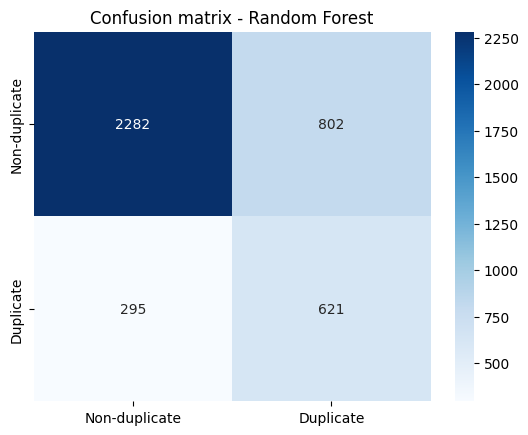

In [ ]:
# Random Forest confusion matrix
# cmap=plt.cm.copper
sns.heatmap(rf_cf  , annot=True  , fmt = "d" , cmap = "Blues" , xticklabels=["Non-duplicate" , "Duplicate"] , yticklabels=["Non-duplicate" , "Duplicate"])
plt.title("Confusion matrix - Random Forest" , fontsize = 12)

- True Negative (TN): 2282

  Model correctly predicted "not duplicate" for actual "not duplicate" questions.

- False Positive (FP): 802

  Model predicted "duplicate" when the actual was "not duplicate." This is a cost, as these are incorrectly marked as duplicates.

- False Negative (FN): 295

  Model predicted "not duplicate" when the actual was "duplicate." This is also a loss since real duplicate questions are missed.

- True Positive (TP): 621

  Model correctly predicted "duplicate" for actual "duplicate" questions.

In [ ]:
from xgboost import XGBClassifier
XG_tf = XGBClassifier()
XG_tf.fit(x_train , y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = XG_tf.predict(x_test)
print("Accuracy Score - " , accuracy_score(y_test , y_pred))

Accuracy Score -  0.69325


In [ ]:
XG_cf = confusion_matrix(y_test , y_pred)
XG_cf

array([[2513,   64],
       [1163,  260]])

<Axes: >

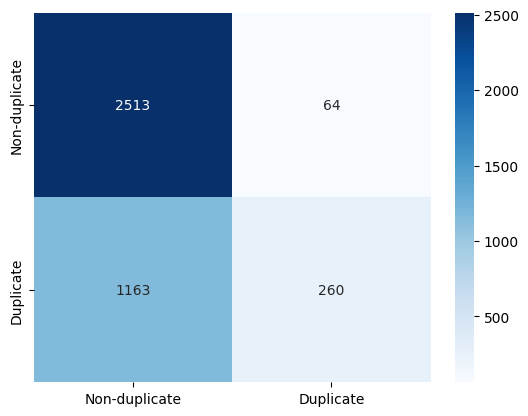

In [ ]:
sns.heatmap(XG_cf , annot = True , fmt = "d" , cmap = "Blues"  , xticklabels=["Non-duplicate" , "Duplicate"] , yticklabels=["Non-duplicate" , "Duplicate"])

- True Negative (TN): 2513

  Model correctly predicted "not duplicate" on truly "not duplicate" pairs.

- False Positive (FP): 64

  Model incorrectly predicted "duplicate" on "not duplicate" pairs. These are “lost” predictions.

- False Negative (FN): 1163

  Model incorrectly predicted "not duplicate" on "duplicate" pairs—a significant loss

- True Positive (TP): 260

  Model correctly predicted "duplicate" on truly "duplicate" pairs—a “benefit.”

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_tf = DecisionTreeClassifier(
    criterion = "gini" ,
    max_depth = 99 ,
    max_features  = "sqrt" ,

)
dt_tf.fit(x_train , y_train)

DecisionTreeClassifier(max_depth=99, max_features='sqrt')

In [ ]:
y_pred = dt_tf.predict(x_test)
print("Accuracy Score - " , accuracy_score(y_pred , y_test))

Accuracy Score -  0.6845


In [ ]:
dt_cf = confusion_matrix(y_test , y_pred)
dt_cf

array([[2529,   48],
       [1214,  209]])

Text(0.5, 1.0, 'Confusion matrix - Decision Tree')

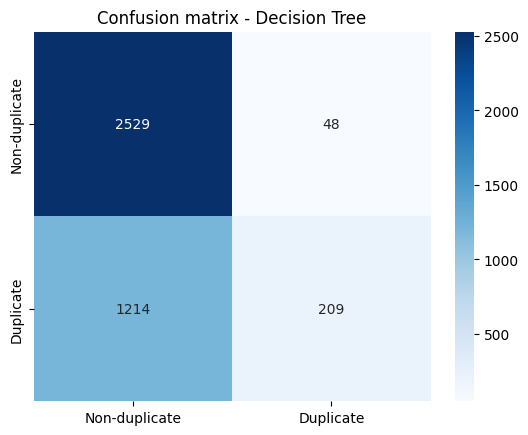

In [ ]:
sns.heatmap(dt_cf , annot = True , fmt = "d" , cmap = "Blues" , xticklabels=["Non-duplicate" , "Duplicate"] , yticklabels=["Non-duplicate" , "Duplicate"])
plt.title("Confusion matrix - Decision Tree")

- True Negatives (TN): 2529

  Model correctly predicted non-duplicate pairs as not duplicate.

- False Positives (FP): 48

  Model incorrectly predicted non-duplicate pairs as duplicate.

- False Negatives (FN): 1214

  Model incorrectly predicted duplicate pairs as not duplicate.

- True Positives (TP): 209

  Model correctly predicted duplicate pairs as duplicate

In [ ]:
# cross validation
from sklearn.model_selection import cross_val_score
rf_tf_cross = cross_val_score(rf_tf , x_train  , y_train , cv = 5)
print("Random Forest Cross Validation Score :" , round(rf_tf_cross.mean() *100 , 2).astype("str") + "%")

Random Forest Cross Validation Score : 71.61%


In [ ]:
xg_tf_cross = cross_val_score(XG_tf , x_train  , y_train , cv = 5)
print("XGBoost Cross Validation Score - " , round(xg_tf_cross.mean() * 100 , 2).astype("str") + "%")


XGBoost Cross Validation Score -  68.22%


In [ ]:
dt_tf_cross = cross_val_score(dt_tf , x_train  , y_train , cv = 5)
print("Decision Tree Cross Validation Score - " , round(dt_tf_cross.mean() * 100 , 2).astype("str") + "%")


Decision Tree Cross Validation Score -  67.46%


# **Bag-of-words**

**In Natural Language Processing (NLP) text data needs to be converted into numbers so that machine learning algorithms can understand it. One common method to do this is Bag of Words (BoW) model. It turns text like sentence, paragraph or document into a collection of words and counts how often each word appears but ignoring the order of the words. It does not consider the order of the words or their grammar but focuses on counting how often each word appears in the textIn Natural Language Processing (NLP) text data needs to be converted into numbers so that machine learning algorithms can understand it. One common method to do this is Bag of Words (BoW) model. It turns text like sentence, paragraph or document into a collection of words and counts how often each word appears but ignoring the order of the words. It does not consider the order of the words or their grammar but focuses on counting how often each word appears in the text**

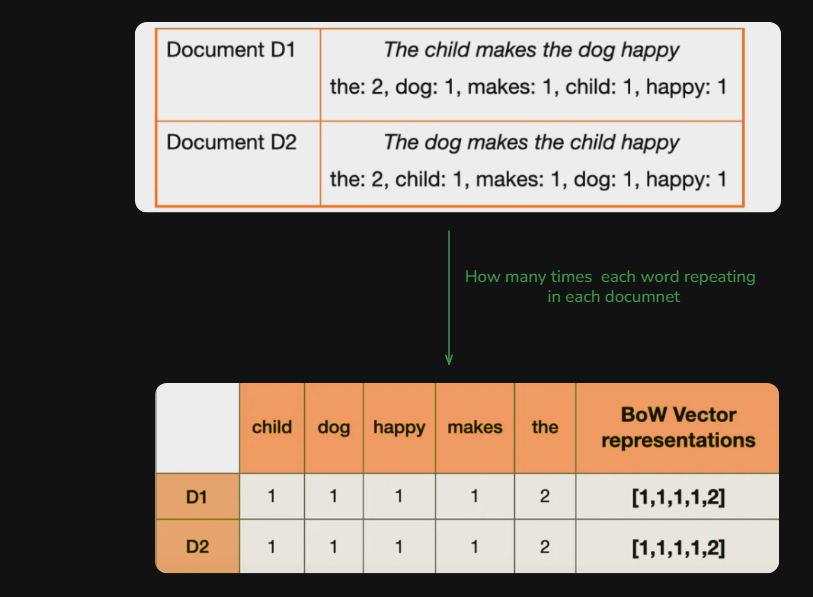

In [ ]:
df.shape

(404290, 6)

In [ ]:
# consider only 10000 data
new_df = df.sample(10000)

In [ ]:
# Is there any null value present?
new_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [ ]:
# Is there any duplicate data present?
new_df.duplicated().sum()

0

In [ ]:
ques_df = new_df[["question1" , "question2"]]
ques_df.head()

,question1,question2
353221,How do I follow up with someone in WhatsApp?,How can I follow someone on WhatsApp?
185933,How can I get a meeting with Elon Musk?,How can I meet Elon Musk?
262198,"Can I make 60,000 a month playing poker?",Can I make thousands a month playing poker?
65873,What are the indicators of a developing country?,What is the development of a country and What ...
95363,How do ammonia and sodium hydroxide react?,How do zinc oxide and sodium hydroxide react?


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df["question1"]) + list(ques_df["question2"])

cv = CountVectorizer(max_features=3000)
q1_arr  , q2_arr = np.vsplit(cv.fit_transform(questions).toarray() , 2)

In [ ]:
# 3000 featurename
cv.get_feature_names_out()

array(['000', '10', '100', ..., 'zealand', 'zero', 'zone'], dtype=object)

In [ ]:
# Vacabulary
cv.vocabulary_

{'how': 1303,
 'do': 793,
 'follow': 1063,
 'up': 2805,
 'with': 2949,
 'someone': 2475,
 'in': 1349,
 'whatsapp': 2920,
 'can': 436,
 'get': 1145,
 'meeting': 1675,
 'make': 1616,
 '60': 50,
 '000': 0,
 'month': 1733,
 'playing': 2002,
 'poker': 2012,
 'what': 2918,
 'are': 209,
 'the': 2676,
 'of': 1836,
 'developing': 753,
 'country': 641,
 'and': 166,
 'sodium': 2463,
 'react': 2170,
 'invest': 1400,
 'city': 531,
 'enterprise': 915,
 'solutions': 2471,
 '10': 1,
 'greatest': 1196,
 'you': 2992,
 've': 2835,
 'got': 1176,
 '24': 32,
 'hours': 1301,
 'to': 2716,
 'live': 1564,
 'will': 2937,
 'spend': 2503,
 'your': 2994,
 'last': 1500,
 'day': 699,
 'on': 1853,
 'earth': 847,
 'become': 306,
 'millionaire': 1704,
 'is': 1416,
 'does': 798,
 'chinese': 519,
 'phrase': 1966,
 'mean': 1663,
 'motivate': 1743,
 'yourself': 2995,
 'work': 2959,
 'hard': 1238,
 'understand': 2788,
 'programming': 2091,
 'language': 1494,
 'better': 333,
 'than': 2674,
 'who': 2928,
 'world': 2965,
 'talk

In [ ]:
temp_df1 = pd.DataFrame(q1_arr , index=ques_df.index)
temp_df2 = pd.DataFrame(q2_arr , index=ques_df.index)
temp_df = pd.concat([temp_df1 , temp_df2])
temp_df.shape
#  5000 feature from question 1 +  5000 feature from question 2 == 10000 features

(20000, 3000)

In [ ]:
temp_df

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
353221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
185933,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
262198,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277312,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
201562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
346798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
195101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
temp_df["is_duplicate"] = new_df["is_duplicate"]

In [ ]:
temp_df

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,is_duplicate
353221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
185933,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
262198,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277312,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
201562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
346798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
195101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Splitting data into 80-20 %
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(temp_df.iloc[: , 0:-1].values , temp_df.iloc[: , -1] , test_size = 0.2 , random_state = 1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , precision_score , recall_score
rf = RandomForestClassifier()
rf.fit(x_train , y_train)
y_pred = rf.predict(x_test)
print("Accuracy sCore - " , accuracy_score(y_test , y_pred))

Accuracy sCore -  0.747


In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(x_train  , y_train)
y_pred = xgb.predict(x_test)
print("Accuracy Score  - " , accuracy_score(y_pred, y_test))

Accuracy Score  -  0.72025


# **BOW - Basic features / Feature Engneering**

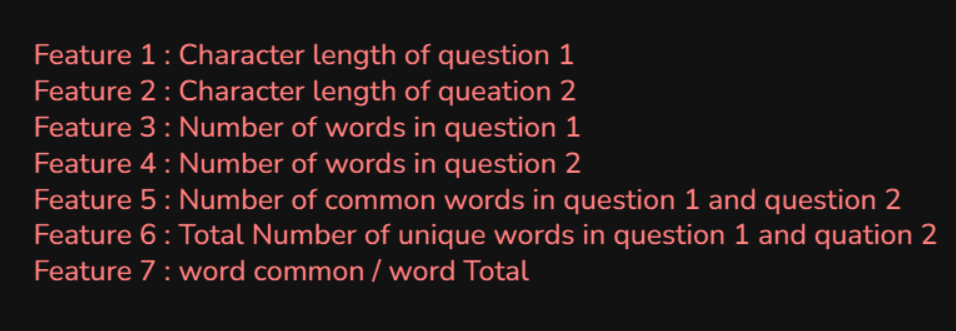

In [ ]:
# 1 -  lengh of  question 1
# 2 -  lengh of  question 2
# 3 -  No words in question 1
# 4 -  No words in question 2
# 5 -  No of common words in question 1 + question 2
# 6 -  Total Number of unique words in question 1 + question 2
# 7 -  word common / word Total

In [ ]:
new_df = df.sample(30000 , random_state = 2)

In [ ]:
# Is there any null value present?
new_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [ ]:
# Is there any duplicate data present
new_df.duplicated().sum()

0

is_duplicate
0    19013
1    10987
Name: count, dtype: int64
is_duplicate
0    63.376667
1    36.623333
Name: count, dtype: float64


<Axes: xlabel='is_duplicate'>

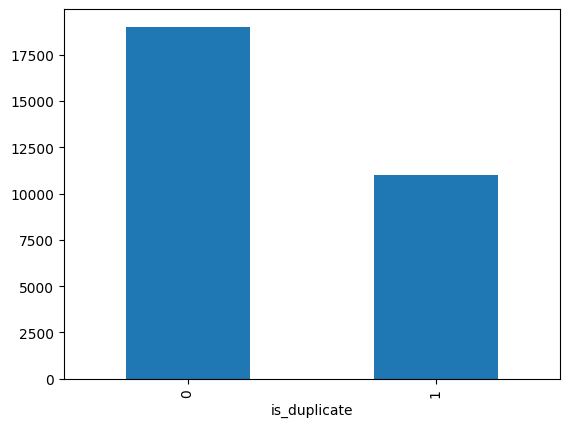

In [ ]:
# Distribution of duplicate and non-deuplicate questions
print(new_df["is_duplicate"].value_counts())
print(new_df["is_duplicate"].value_counts() / new_df["is_duplicate"].count() *100)
new_df['is_duplicate'].value_counts().plot(kind='bar')

In [ ]:
# Repeated questions

qid = pd.Series(new_df['qid1'].tolist() + new_df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 55299
Number of questions getting repeated 3480


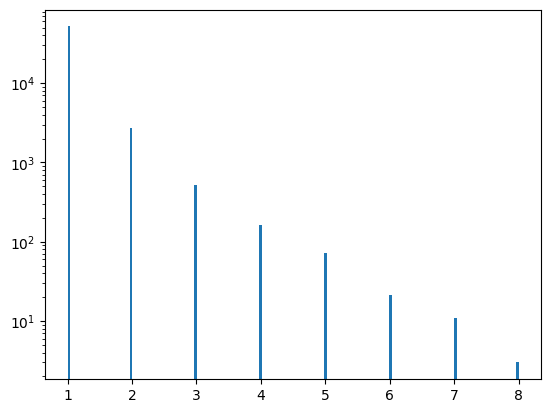

In [ ]:
plt.hist(qid.value_counts().values , bins = 160)
plt.yscale("log")
plt.show()

**Feature Engineering**

- feature 1 -  lengh of  question 1

- feature 2 -  lengh of  question 2

In [ ]:
# Feature 1 and Feature 2
new_df["q1_len"] = new_df["question1"].str.len()
new_df["q2_len"] = new_df["question2"].str.len()

In [ ]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,76,77
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0,49,57
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0,105,120
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0,59,146
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0,35,50


- feature 3 -  Number words in question 1
- feature 4 -  Number words in question 2

In [ ]:
# Feature 3 and Feature 4
new_df["q1_num_words"] = new_df["question1"].apply(lambda row : len(row.split(" ")))
new_df["q2_num_words"] = new_df["question2"].apply(lambda row : len(row.split(" ")))

In [ ]:
new_df.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,76,77,12,12


feature 5 -  Number of common words in question 1 + question 2

In [ ]:
# feature 5 Number of common words in question 1 and question 2
def  common_words(row):
  w1 = set(map(lambda word : word.lower().strip() , row["question1"].split(" ")))
  w2 = set(map(lambda word : word.lower().strip() , row["question2"].split(" ")))
  return len(w1 & w2)

In [ ]:
new_df["word_common"] = new_df.apply(common_words , axis = 1)

In [ ]:
new_df.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,76,77,12,12,11


feature 6 -  Total Number of unique words in question 1 + question 2

In [ ]:
# feature 6 Total Number of unique words in question 1 and question 2
def total_words(row):
  w1 = set(map(lambda word : word.lower().strip() , row["question1"].split(" ")))
  w2 = set(map(lambda word : word.lower().strip() , row["question2"].split(" ")))
  return (len(w1) + len(w2))

In [ ]:
new_df["word_total"] = new_df.apply(total_words , axis = 1)

In [ ]:
new_df.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,76,77,12,12,11,24


feature 7 - word_share =  word common / word Total

In [ ]:
# Feature 7
new_df["word_share"] = round(new_df["word_common"] / new_df["word_total"] , 2)

In [ ]:
new_df.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,76,77,12,12,11,24,0.46


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


minimum characters  2
maximum characters  391
average number of characters  59.71


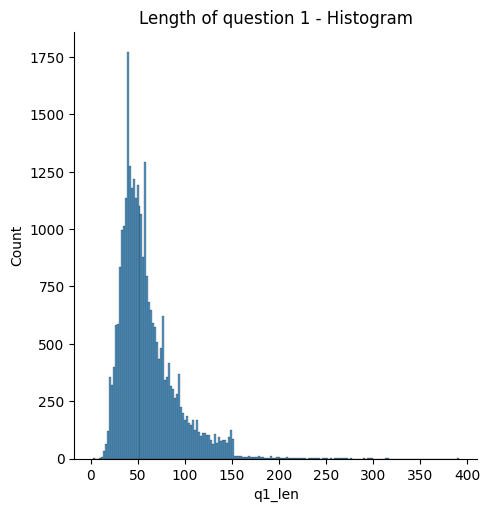

In [ ]:
# Anlalysiz of feature
sns.displot(new_df["q1_len"])
plt.title("Length of question 1 - Histogram")
print("minimum characters " , new_df["q1_len"].min())
print("maximum characters " , new_df["q1_len"].max())
print("average number of characters " , round(new_df["q1_len"].mean() , 2))

- Most of the question length of question 1 lies between 5-150
- Few question are there having a more than 200 length

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


minimum characters  6
maximum characters  391
average number of characters  60.29


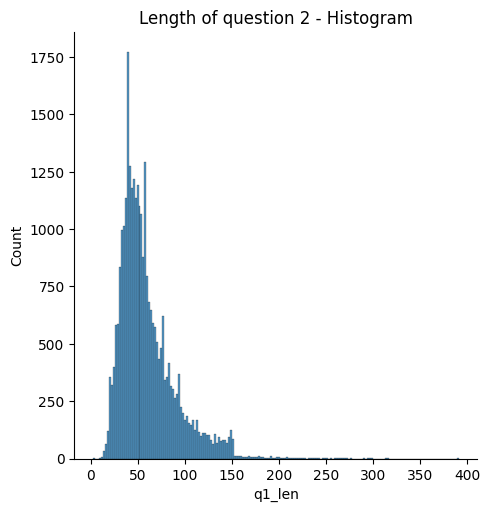

In [ ]:
sns.displot(new_df["q1_len"])
plt.title("Length of question 2 - Histogram")
print("minimum characters " , new_df["q2_len"].min())
print("maximum characters " , new_df["q1_len"].max())
print("average number of characters " , round(new_df["q2_len"].mean() , 2))

- Same as question 1 question 2 length of question is lies between 5-150
- Some few question are there having a more than 150 length

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


minimum words 1
maximum words 72
average number of words 10.97


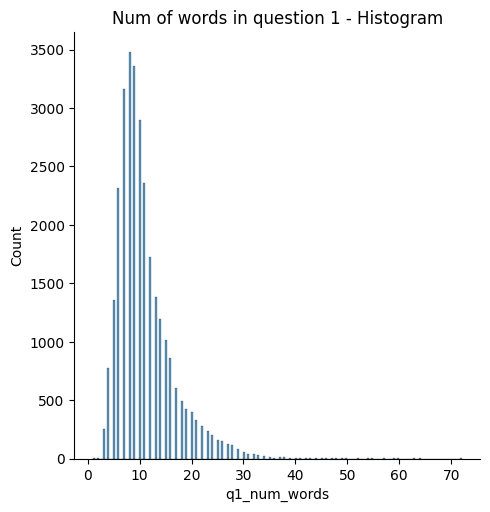

In [ ]:
sns.displot(new_df["q1_num_words"])
plt.title("Num of words in question 1 - Histogram")
print("minimum words" , new_df["q1_num_words"].min())
print("maximum words" , new_df["q1_num_words"].max())
print("average number of words" , round(new_df["q1_num_words"].mean(),2))

**Main Distribution:**
- The concentration of word counts in the 5–30 range suggests that users generally ask brief and direct questions, reflecting common behavior in many text-based

**Long Tail:**
- The small number of questions with more than 30 words forms a long tail in the histogram. These are likely outlier questions that are either very detailed, multi-part, or possibly poorly structured

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


minimum words 1
maximum words 237
average number of words 11.23


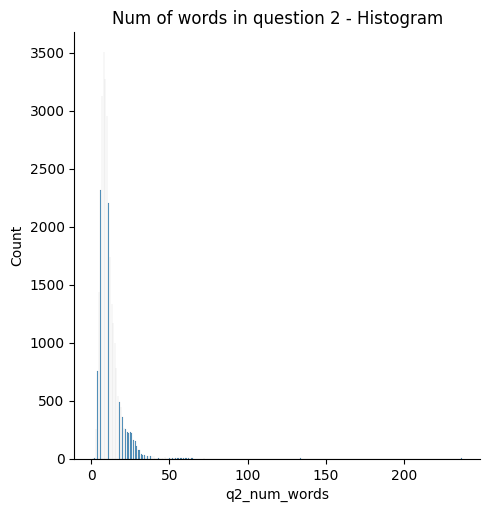

In [ ]:
sns.displot(new_df["q2_num_words"])
plt.title("Num of words in question 2 - Histogram")
print("minimum words" , new_df["q2_num_words"].min())
print("maximum words" , new_df["q2_num_words"].max())
print("average number of words" , round(new_df["q2_num_words"].mean(),2))

/tmp/ipykernel_36/2731693711.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df["is_duplicate"] == 0]["word_common"] , label = "non_duplicate")
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_36/2731693711.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) o

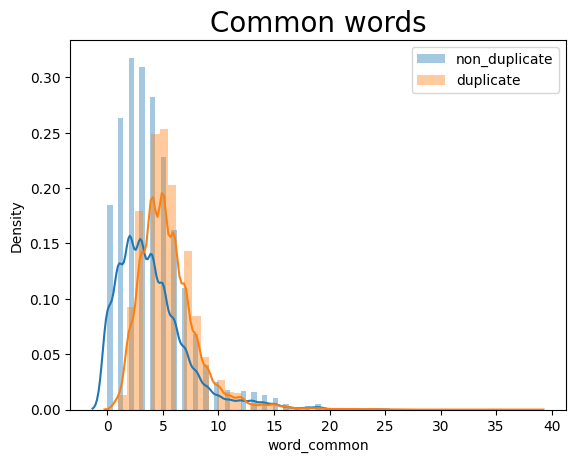

In [ ]:
# common words
sns.distplot(new_df[new_df["is_duplicate"] == 0]["word_common"] , label = "non_duplicate")
sns.distplot(new_df[new_df["is_duplicate"] == 1]["word_common"] , label = "duplicate")
plt.title("Common words" , size = 20)
plt.legend()
plt.show()

**Anlysis of Common word col -**

 - If questions 1 and 2 have fewer than 4 common words, then the probability of those questions being non-duplicates is higher.

 - If questions 1 and 2 have more than 4 common words, then the probability of those questions being duplicates is higher.


/tmp/ipykernel_36/4263819419.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_total'],label='non duplicate')
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_36/4263819419.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `hi

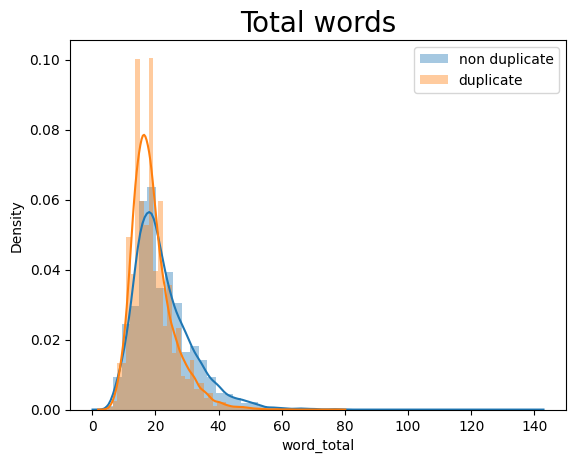

In [ ]:
# total words
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_total'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_total'],label='duplicate')
plt.title("Total words" ,size = 20)
plt.legend()
plt.show()

**Anlysis of Total word col-**
  - If the total number of words is between 0 and 20, then the probability of being a duplicate is higher than being a non-duplicate.

  - If the total number of words is more than 40, then the probability of being a non-duplicate is higher than being a duplicate.

/tmp/ipykernel_36/542246512.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_share'],label='non duplicate')
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_36/542246512.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `hist

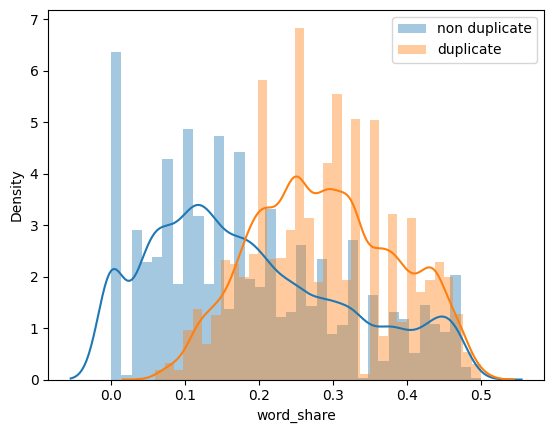

In [ ]:
# word share
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

Anlysis word common / word Total
  - If the word share value is 0.2 or less, then the probability of being non-duplicate is higher.

  - If the word share value is greater than 0.2, then the probability of being duplicate is higher.

In [ ]:
ques_df = new_df[["question1" , "question2"]]
ques_df.head()

,question1,question2
398782,What is the best marketing automation tool for...,What is the best marketing automation tool for...
115086,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...
327711,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...
367788,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...
151235,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...


In [ ]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print("Shape of final_df -" , final_df.shape)
final_df.head()

Shape of final_df - (30000, 8)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,1,76,77,12,12,11,24,0.46
115086,0,49,57,12,15,7,23,0.30
327711,0,105,120,25,17,2,34,0.06
367788,0,59,146,12,30,0,32,0.00
151235,0,35,50,5,9,3,13,0.23


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
questions = list(ques_df["question1"]) + list(ques_df["question2"])

cv = CountVectorizer(max_features= 3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [ ]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [ ]:
# merge temp_df with final_df
final_df = pd.concat([temp_df , final_df] , axis = 1)
print(final_df.shape)
final_df

(30000, 6008)


,0,1,2,3,4,5,6,7,8,9,...,2998,2999,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,0,0,0,0,0,0,0,0,0,0,...,0,0,1,76,77,12,12,11,24,0.46
115086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,49,57,12,15,7,23,0.30
327711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,105,120,25,17,2,34,0.06
367788,0,0,0,0,0,0,0,0,0,0,...,0,0,0,59,146,12,30,0,32,0.00
151235,0,0,0,0,0,0,0,0,0,0,...,0,0,0,35,50,5,9,3,13,0.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243932,0,0,0,0,0,0,0,0,0,0,...,0,0,1,42,41,7,7,6,14,0.43
91980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,68,61,12,12,4,24,0.17
266955,0,0,0,0,0,0,0,0,0,0,...,0,0,0,73,98,14,17,4,30,0.13
71112,0,0,0,0,0,0,0,0,0,0,...,0,0,1,51,45,10,10,5,20,0.25


In [ ]:
# This is how our final_df look like
final_df

,0,1,2,3,4,5,6,7,8,9,...,2998,2999,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,0,0,0,0,0,0,0,0,0,0,...,0,0,1,76,77,12,12,11,24,0.46
115086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,49,57,12,15,7,23,0.30
327711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,105,120,25,17,2,34,0.06
367788,0,0,0,0,0,0,0,0,0,0,...,0,0,0,59,146,12,30,0,32,0.00
151235,0,0,0,0,0,0,0,0,0,0,...,0,0,0,35,50,5,9,3,13,0.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243932,0,0,0,0,0,0,0,0,0,0,...,0,0,1,42,41,7,7,6,14,0.43
91980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,68,61,12,12,4,24,0.17
266955,0,0,0,0,0,0,0,0,0,0,...,0,0,0,73,98,14,17,4,30,0.13
71112,0,0,0,0,0,0,0,0,0,0,...,0,0,1,51,45,10,10,5,20,0.25


In [ ]:
# splitting the data into 80% and 20% part --> 80% would be train data and 20% would be test data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [ ]:
# RandomForest
rf = RandomForestClassifier()
rf.fit(x_train  , y_train)
y_pred = rf.predict(x_test)
print("Accuracy Score - " , accuracy_score(y_pred , y_test))

Accuracy Score -  0.9976666666666667


In [ ]:
# from xgboost import XGBClassifier
# xgb = XGBClassifier()
# xgb.fit(x_train,y_train)
# y_pred = xgb.predict(x_test)
# accuracy_score(y_test,y_pred)

# **BOW Preprocessing and advanced features**


1. Token Features

  - cwc_min: This is the ratio of the number of common words to the length of the smaller question
  - cwc_max: This is the ratio of the number of common words to the length of the larger question
  - csc_min: This is the ratio of the number of common stop words to the smaller stop word count among the two questions
  - csc_max: This is the ratio of the number of common stop words to the larger stop word count among the two questions
  - ctc_min: This is the ratio of the number of common tokens to the smaller token count among the two questions
  - ctc_max: This is the ratio of the number of common tokens to the larger token count among the two questions
  - last_word_eq: 1 if the last word in the two questions is same, 0 otherwise
  - first_word_eq: 1 if the first word in the two questions is same, 0 otherwise

2. Length Based Features
  - mean_len: Mean of the length of the two questions (number of words)
  - abs_len_diff: Absolute difference between the length of the two questions (number of words)
  - longest_substr_ratio: Ratio of the length of the longest substring among the two questions to the length of the smaller question

3. Fuzzy Features
  - fuzz_ratio: fuzz_ratio score from fuzzywuzzy
  - fuzz_partial_ratio: fuzz_partial_ratio from fuzzywuzzy
  token_sort_ratio: token_sort_ratio from fuzzywuzzy
  - token_set_ratio: token_set_ratio from fuzzywuzzy


In [ ]:
# cwc_min (ratio of number of common words  to the length of smallest question) = Number of common words / min(words(q1 , a2))
# cwc_max (ratio of number of common words  to the length of highest question) = Number of common words / max(words(q1 , a2))
# csc_min  = Number of common stopwords / min(stopwords(q1 , q2))
# csc_max  = Number of common stopwords / max(stopwords(q1 , q2))

# ctc_min  = Number of common tokens / min(tokens(q1 , q2))
# ctc_max  = Number of common tokens / max(tokens(q1 , q2))

# last_word_equal =
#   - Example --> Hellow how are you
#                 I am fine
#                 Last word of both senetence (you , fine) are not equal then it is 0

# first_word_equal =
#   - Example --> Hello how are you
#                 I am fine
#                 first word of both senetence (Hello , I) are not equal then it is 0

#  Length based feature
# mean length - mean of the length of 2 question
# abs_length_diff
# Longest_substring_ratio -



In [ ]:
# Data Preprocessing
import re
from bs4 import BeautifulSoup
def preprocess(q):

    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()


    return q

In [ ]:
new_df["question1"] = new_df["question1"].apply(preprocess)
new_df["question2"] = new_df["question2"].apply(preprocess)

In [ ]:
new_df.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,76,77,12,12,...,0.923076,1.0,1.0,0.0,13.0,0.855263,99,99,99,99


In [ ]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Advanced Features
# cwc_min (ratio of number of common words  to the length of smallest question) = Number of common words / min(words(q1 , a2))
# cwc_max (ratio of number of common words  to the length of highest question) = Number of common words / max(words(q1 , a2))

# csc_min  = Number of common stopwords / min(stopwords(q1 , q2))
# csc_max  = Number of common stopwords / max(stopwords(q1 , q2))

# ctc_min  = Number of common tokens / min(tokens(q1 , q2))
# ctc_max  = Number of common tokens / max(tokens(q1 , q2))

# last_word_equal =
#   - Example --> Hellow how are you
#                 I am fine
#                 Last word of both senetence (you , fine) is not equal then it is 0

# first_word_equal =
#   - Example --> Hello how are you
#                 I am fine
#                 first word of both senetence (Hello , I) is not equal then it is 0


from nltk.corpus import stopwords
def fetch_token_features(row):

  q1 = row["question1"]
  q2 = row["question2"]

  safe_div = 0.00001

  stop_words = stopwords.words("english")

  token_features =[0.0]*8

  # converting sentence into tokens

  q1_tokens = q1.split()
  q2_tokens = q2.split()

  if len(q1_tokens) == 0 or len(q2_tokens) == 0:
    return token_features





  # get the non-stopwords in questions
  q1_words = set([word for word in q1_tokens if word not in stop_words])
  q2_words = set([word for word in q2_tokens if word not in stop_words])

  # get the stopwords in questions
  q1_stops = set([word for word in q1_tokens if word in stop_words])
  q2_stops = set([word for word in q2_tokens if word in stop_words])

  # get the common non-stopwords question pair
  common_word_count = len(q1_words.intersection(q2_words))

  # get the common stopwords from question pair
  common_stop_count = len(q1_stops.intersection(q2_stops))

  # get the common Tokens from question pair
  common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

  token_features[0] = common_word_count / (min(len(q1_words) , len(q2_words)) + safe_div)
  token_features[1] = common_word_count / (max(len(q1_words) , len(q2_words)) + safe_div)

  token_features[2] = common_stop_count / (min(len(q1_stops) , len(q2_stops)) + safe_div)
  token_features[3] = common_stop_count / (max(len(q1_stops) , len(q2_stops)) + safe_div)

  token_features[4] = common_token_count / (min(len(q1_tokens) , len(q2_tokens)) + safe_div)
  token_features[5] = common_token_count / (max(len(q1_tokens) , len(q2_tokens)) + safe_div)

  # Last word of both question is same or not
  token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

  # First word of both question is same or not
  token_features[7] = int(q1_tokens[0] == q2_tokens[0])

  return token_features


In [ ]:
token_features = new_df.apply(fetch_token_features , axis = 1)

In [ ]:
new_df["cwc_min"] = list(map(lambda x: x[0]  , token_features))
new_df["cwc_max"] = list(map(lambda x: x[1]  , token_features))

new_df["csc_min"] = list(map(lambda x: x[2]  , token_features))
new_df["csc_max"] = list(map(lambda x: x[3]  , token_features))

new_df["ctc_min"] = list(map(lambda x: x[4]  , token_features))
new_df["ctc_max"] = list(map(lambda x: x[5]  , token_features))

new_df["last_word_eq"] = list(map(lambda x: x[6]  , token_features))
new_df["first_word_eq"] = list(map(lambda x: x[7]  , token_features))

In [ ]:
# Structure of new_df
new_df.shape

(30000, 28)

In [ ]:
!pip install Distance

In [ ]:
#  Length based feature
# mean length - mean of the length of 2 question
# abs_length_diff
# Longest_substring_ratio


import distance

def fetch_length_features(row):

    q1 = row['question1']
    q2 = row['question2']

    length_features = [0.0]*3

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)

    return length_features



In [ ]:
length_features = new_df.apply(fetch_length_features , axis = 1)

new_df["abs_len_diff"] = list(map(lambda x: x[0] , length_features))
new_df["mean_len"] = list(map(lambda x: x[1] , length_features))
new_df["longest_substr_ratio"] = list(map(lambda x: x[2] , length_features))

In [ ]:
!pip install fuzzywuzzy

In [ ]:
# Fuzzy Features
from fuzzywuzzy import fuzz
def fetch_fuzzy_feature(row):
  q1 = row["question1"]
  q2 = row["question2"]

  fuzzy_feature = [0.0] * 4

  # fuzzy_ratio
  fuzzy_feature[0] = fuzz.QRatio(q1 , q2)

  # fuzzy_partial_ratio
  fuzzy_feature[1] = fuzz.partial_ratio(q1 , q2)

  # token_sort_ratio
  fuzzy_feature[2] = fuzz.token_sort_ratio(q1  , q2)

  # token_set_ratio
  fuzzy_feature[3] = fuzz.token_set_ratio(q1 , q2)

  return fuzzy_feature

In [ ]:
fuzzy_feature = new_df.apply(fetch_fuzzy_feature , axis = 1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_feature))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_feature))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_feature))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_feature))

In [ ]:
new_df.shape

(30000, 28)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

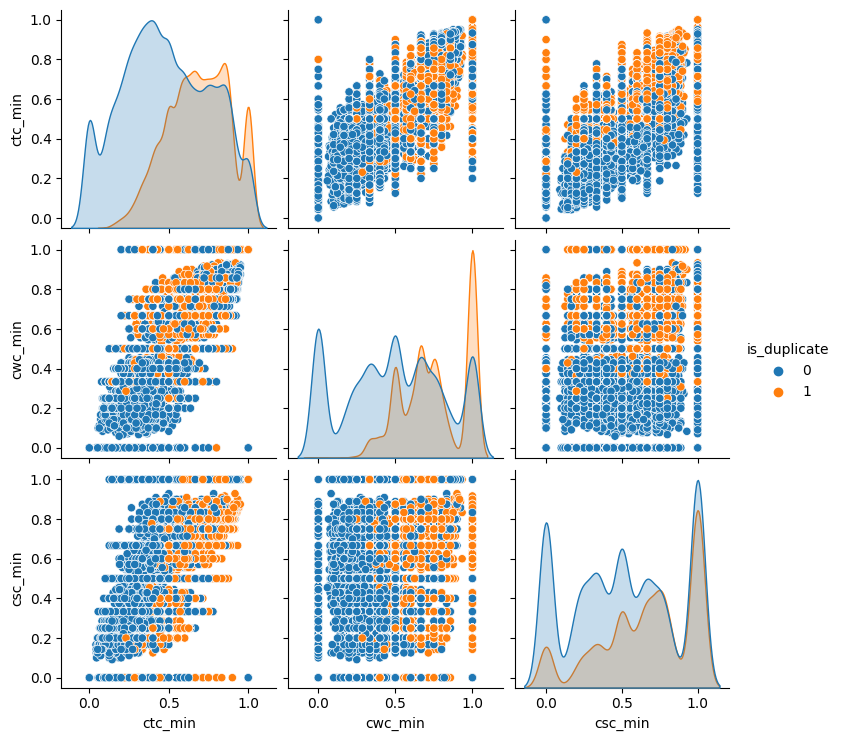

In [ ]:
# Distribution of columns
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

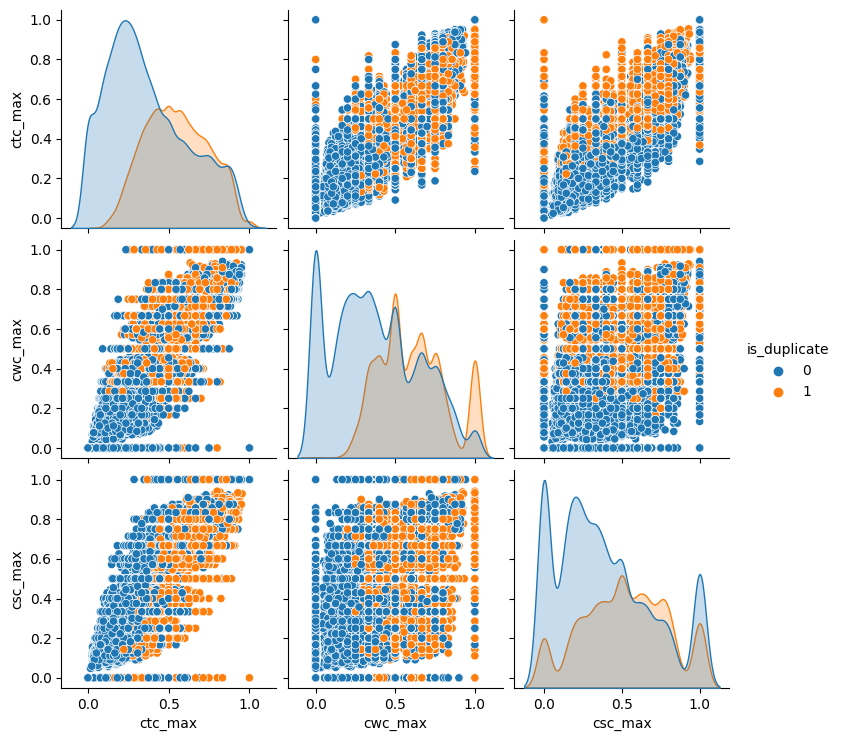

In [ ]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

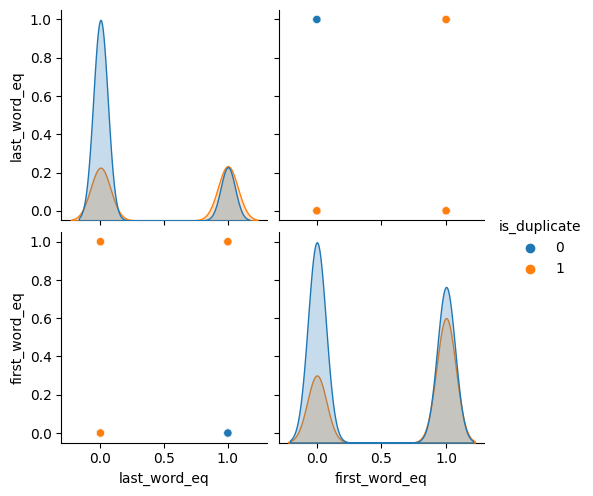

In [ ]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

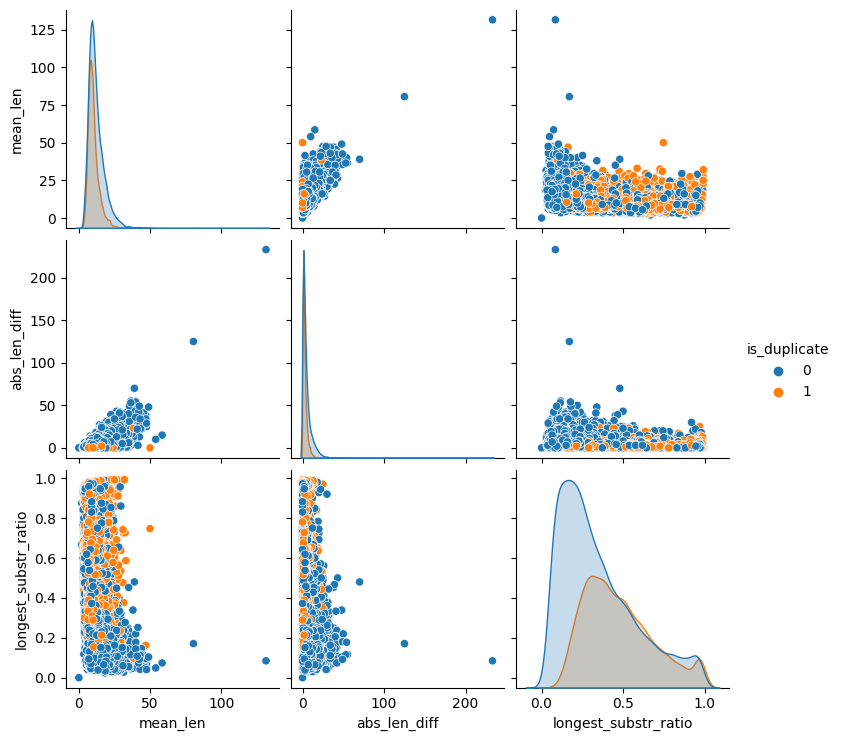

In [ ]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
x = MinMaxScaler().fit_transform(new_df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = new_df["is_duplicate"].values

In [ ]:
from sklearn.manifold import TSNE
tsne2d = TSNE(
    n_components= 2 ,
    init= "random" ,
    random_state = 101 ,
    method = "barnes_hut" ,
    n_iter = 1000 ,
    verbose = 2 ,
    angle = 0.5
).fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.066s...
[t-SNE] Computed neighbors for 30000 samples in 5.261s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


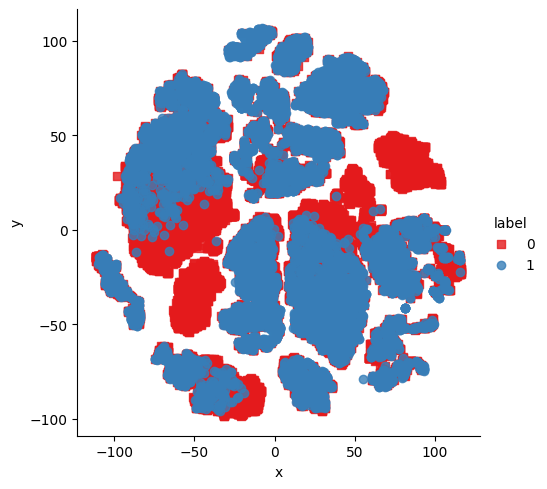

In [ ]:
x_df = pd.DataFrame({"x":tsne2d[: , 0] , "y" : tsne2d[: , 1] , "label" : y})
sns.lmplot(data=x_df, x='x', y='y', hue='label', fit_reg=False,palette="Set1",markers=['s','o'])

In [ ]:
# from sklearn.manifold import TSNE
# tsne3d = TSNE(
#     n_components= 3 ,
#     init= "random" ,
#     random_state = 101 ,
#     method = "barnes_hut" ,
#     n_iter = 1000 ,
#     verbose = 2 ,
#     angle = 0.5
# ).fit_transform(x)

In [ ]:
# import plotly.express as px

# import plotly.graph_objs as go
# import plotly.tools as tls
# import plotly.offline as py
# py.init_notebook_mode(connected=True)

# trace1 = go.Scatter3d(
#     x=tsne3d[:,0],
#     y=tsne3d[:,1],
#     z=tsne3d[:,2],
#     mode='markers',
#     marker=dict(
#         sizemode='diameter',
#         color = y,
#         colorscale = 'Portland',
#         colorbar = dict(title = 'duplicate'),
#         line=dict(color='rgb(255, 255, 255)'),
#         opacity=0.75
#     )
# )

# data=[trace1]
# layout=dict(height=800, width=800, title='3d embedding with engineered features')
# fig=dict(data=data, layout=layout)
# py.iplot(fig, filename='3DBubble')

In [ ]:
ques_df = new_df[['question1','question2']]
ques_df.head()

,question1,question2
398782,what is the best marketing automation tool for...,what is the best marketing automation tool for...
115086,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...
327711,i am from india and live abroad i met a guy fr...,t i e t to thapar university to thapar univers...
367788,why do so many people in the u s hate the sout...,my boyfriend doesnt feel guilty when he hurts ...
151235,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy


In [ ]:
final_df = new_df.drop(columns = ["id" ,	"qid1" ,	"qid2" , 	"question1" , 	"question2"])
final_df.shape

(30000, 23)

In [ ]:
# countvectorize
question = list(new_df["question1"]) + list(new_df["question2"])

cv = CountVectorizer(max_features=3000)
q1_arr ,q2_arr = np.vsplit(cv.fit_transform(question).toarray() ,2)

In [ ]:
temp_df1 = pd.DataFrame(q1_arr , index = ques_df.index)
temp_df2 = pd.DataFrame(q2_arr , index = ques_df.index)
tem_df = pd.concat([temp_df1 , temp_df2] , axis = 1)
temp_df.shape

(30000, 6000)

In [ ]:
final_df = pd.concat([final_df , temp_df] , axis = 1)
final_df.shape

(30000, 6023)

In [ ]:
# Split data into 80 20% part --? 80% would be train data and 20 % would be test data
x_train , x_test , y_train , y_test = train_test_split(final_df.iloc[: , 1:].values , final_df.iloc[: , 0].values , test_size  = .2)

In [ ]:
rf_BOWA = RandomForestClassifier()
rf_BOWA.fit(x_train , y_train)
y_pred = rf_BOWA.predict(x_test)
print("Accuracy Score - " , accuracy_score(y_pred , y_test))

Accuracy Score -  0.7858333333333334


In [ ]:
XGB_BOWA = XGBClassifier()
XGB_BOWA.fit(x_train,y_train)
y_pred1 = XGB_BOWA.predict(x_test)
print("Accuracy Score - " , accuracy_score(y_test,y_pred1))

Accuracy Score -  0.7965


In [ ]:
from sklearn.metrics import confusion_matrix
rf_cf = confusion_matrix(y_test,y_pred)
rf_cf

array([[3244,  551],
       [ 734, 1471]])

Text(0.5, 1.0, 'Confusion matrix - Random Forest')

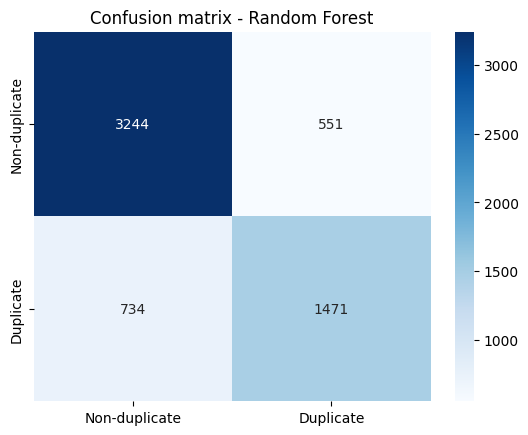

In [ ]:
# Random Forest confusion matrix
# cmap=plt.cm.copper
sns.heatmap(rf_cf  , annot=True  , fmt = "d" , cmap = "Blues" , xticklabels=["Non-duplicate" , "Duplicate"] , yticklabels=["Non-duplicate" , "Duplicate"])
plt.title("Confusion matrix - Random Forest" , fontsize = 12)

- True Negatives (3244): These are the cases where the model correctly predicted questions as not duplicates.

- False Positives (551): The model incorrectly predicted unique questions as duplicates (Type I error).

- False Negatives (734): The model missed duplicate questions and predicted them as unique (Type II error).

- True Positives (1471): The model correctly identified actual duplicates.

In [ ]:
xg_cf = confusion_matrix(y_test,y_pred1)
xg_cf

array([[3177,  618],
       [ 603, 1602]])

Text(0.5, 1.0, 'Confusion matrix - XGBoost')

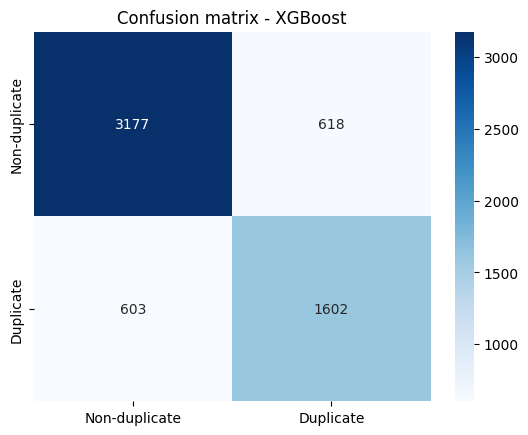

In [ ]:
# XGBoost confusion matrix
sns.heatmap(xg_cf  , annot=True ,fmt = "d" , cmap = "Blues" , xticklabels=["Non-duplicate" , "Duplicate"] , yticklabels=["Non-duplicate" , "Duplicate"])
plt.title("Confusion matrix - XGBoost" , fontsize = 12)

- True Negatives (TN): 3177 — Model correctly identified non-duplicate pairs.

- False Positives (FP): 618 — Model incorrectly Identify unique questions as duplicates (Type I error).

- False Negatives (FN): 603 — Model missed some duplicate pairs, marking them as unique (Type II error). We likely more to be focus on FN beacause if questions are `duplicate` but my model label that questions as `Non-duplicate` then it would be cost for me

- True Positives (TP): 1602 — Model correctly predicted duplicate question pairs.

- As compare to our previous Random forest model XGBoost lower FN means it detects duplicates more reliably than Random Forest in our case.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_BOWA = DecisionTreeClassifier(
    criterion = "gini" ,
    max_depth = 99 ,
    max_features  = "sqrt" ,

)
dt_BOWA.fit(x_train , y_train)

DecisionTreeClassifier(max_depth=99, max_features='sqrt')

In [ ]:
y_pred = dt_BOWA.predict(x_test)
print("Accuracy Score - " , accuracy_score(y_pred , y_test))

Accuracy Score -  0.7115


In [ ]:
dt_cf  = confusion_matrix(y_pred , y_test)
dt_cf

array([[2973,  909],
       [ 822, 1296]])

Text(0.5, 1.0, 'Confusion matrix - Decision Tree')

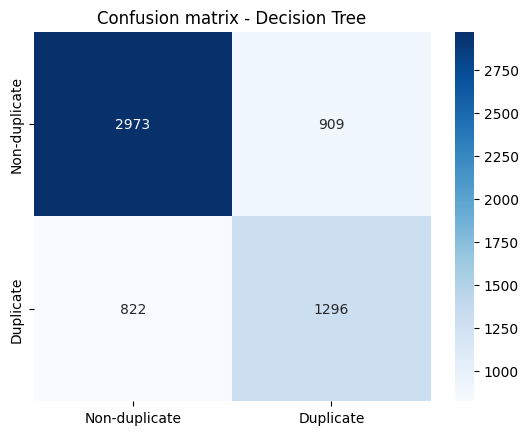

In [ ]:
sns.heatmap(dt_cf , annot = True ,fmt = "d" ,xticklabels=("Non-duplicate" , "Duplicate") , yticklabels=("Non-duplicate", "Duplicate") , cmap = "Blues")
plt.title("Confusion matrix - Decision Tree")

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(x_train , y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred = LR.predict(x_test)
print("Accuracy Score - " , accuracy_score(y_pred , y_test))

Accuracy Score -  0.7258333333333333


In [ ]:
lr_cf = confusion_matrix(y_pred , y_test)
lr_cf

array([[3087,  937],
       [ 708, 1268]])

Text(0.5, 1.0, 'Confusion matrix - Logistic Rrgression')

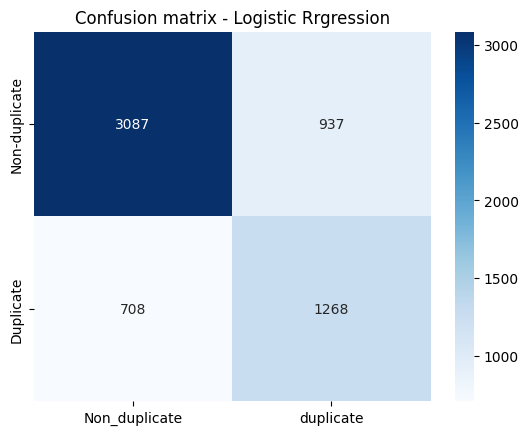

In [ ]:
sns.heatmap(lr_cf , annot = True , fmt = "d"  , cmap = "Blues", xticklabels=("Non_duplicate" , "duplicate") , yticklabels=("Non-duplicate" , "Duplicate"))
plt.title("Confusion matrix - Logistic Rrgression")

In [ ]:
def test_common_words(q1 , q2):
  w1 = set(map(lambda word: word.lower().strip() , q1.split(" ")))
  w2 = set(map(lambda word: word.lower().strip() , q2.split(" ")))

  return len(w1 & w2)

def test_total_words(q1 , q2):
  w1 = set(map(lambda word : word.lower().strip() , q1.split(" ")))
  w2 = set(map(lambda word : word.lower().strip() , q2.split(" ")))

  return (len(w1) + len(w2))

def test_fetch_token_features(q1 , q2):

  safe_div = 0.0001

  stop_words = stopwords.words("english")

  token_features = [0.0] * 8

  # conveeting the sent into tokens
  q1_token = q1.split()
  q2_token = q2.split()

  if len(q1_token) == 0 or len(q2_token) == 0:
    return token_features


  # get the non-stopwords in question
  q1_words = set([word for word in q1_token if word not in stop_words])
  q2_words = set([word for word in q2_token if word not in stop_words])

  # get the stopwords in question
  q1_stops = set([word for word in q1_token if word in stop_words])
  q2_stops = set([word for word in q2_token if word in stop_words])

  # Get the common non-stopwords from Question pair
  common_word_count = len(q1_words.intersection(q2_words))

  # Get the common stopwords from Question pair
  common_stop_count = len(q1_stops.intersection(q2_stops))

  # Get the common Tokens from Question pair
  common_token_count = len(set(q1_token).intersection(set(q2_token)))


  token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + safe_div)
  token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + safe_div)
  token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + safe_div)
  token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + safe_div)
  token_features[4] = common_token_count / (min(len(q1_token), len(q2_token)) + safe_div)
  token_features[5] = common_token_count / (max(len(q2_token), len(q2_token)) + safe_div)

  # Last word of both question is same or not
  token_features[6] = int(q1_token[-1] == q2_token[-1])

  # First word of both question is same or not
  token_features[7] = int(q1_token[0] == q2_token[0])

  return token_features


In [ ]:
def test_fetch_length_fearture(q1 , q2):

  length_features = [0.0]*3

  # converting the sent into Tokens
  q1_tokens = q1.split()
  q2_tokens = q2.split()

  if len(q1_tokens) == 0 or len(q2_tokens) == 0:
    return length_features

  # Absolute length feature
  length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

  #Average Token Length of both Questions
  length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

  strs = list(distance.lcsubstrings(q1, q2))
  length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)

  return length_features


In [ ]:
def test_fetch_fuzzy_features(q1,q2):

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [ ]:
def query_point_creator(q1 , q2):
    input_query = []

    q1 = preprocess(q1)
    q2 = preprocess(q2)

    # basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    input_query.append(test_common_words(q1 , q2))
    input_query.append(test_total_words(q1 , q2))
    input_query.append(round(test_common_words(q1 , q2)/test_total_words(q1 , q2),2))

    # token features
    input_query.extend(test_fetch_token_features(q1 , q2))

    # length features
    input_query.extend(test_fetch_length_fearture(q1 , q2))

    # fuzzy features
    input_query.extend(test_fetch_fuzzy_features(q1,q2))

    # BoW features
    q1_bow = cv.transform([q1]).toarray()
    q2_bow = cv.transform([q2]).toarray()

    return np.hstack((np.array(input_query).reshape(1, -1), q1_bow, q2_bow))


**Testing the model by passing unseen data**

In [ ]:
q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the business capital of India?'

In [ ]:
q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of India?'
rf_BOWA.predict(query_point_creator(q1 , q2))

array([1])

In [ ]:
test = pd.read_csv("/kaggle/input/quora-question-pairs/test.csv")

In [ ]:
test[test["test_id"] == 10].values

array([[10, 'What is the best slideshow app for Android?',
        'What are the best app for android?']], dtype=object)

In [ ]:
def predicted_values(q1 , q2):
  a = rf_BOWA.predict(query_point_creator(q1 , q2))
  if a == 0:
    print(a)
    print("Non-duplicate Question")
  else:
    print(a)
    print("Duplicate Question")

In [ ]:
q1 = "What is the best slideshow app for android?"
q2 = "What are the best app for android?"
predicted_values(q1 , q2)

[1]
Duplicate Question


In [ ]:
test[test["test_id"] == 22].values

array([[22, 'What are the differences between clients and servers?',
        'What is the difference between a server and a database?']],
      dtype=object)

In [ ]:
q1 = "What are the differences between clients and servers?"
q2 = "What is the difference between a server and a database?"
predicted_values(q1 , q2)

[0]
Non-duplicate Question


# **Cross Validation**

**Cross-validation is a statistical method used to estimate the skill of machine learning models. It is used primarily in applied machine learning to estimate the performance of a machine learning algorithm on unseen data. Cross-validation involves partitioning a dataset into a training set and a test set multiple times to ensure the model’s performance is evaluated accurately.**

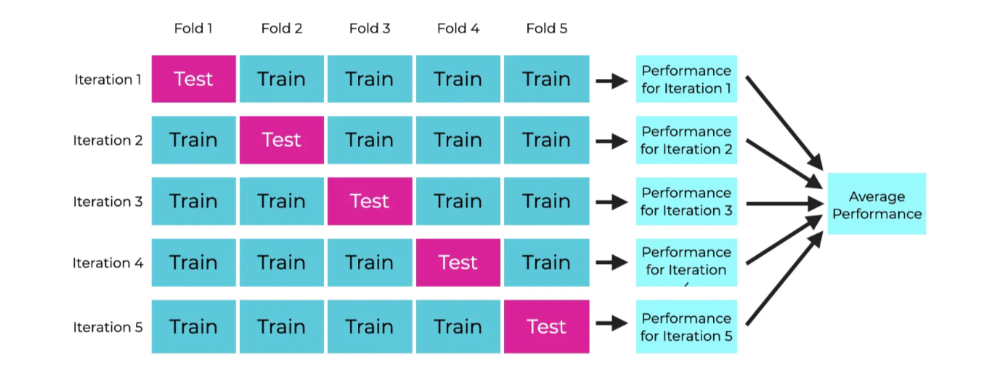

In [ ]:
from sklearn.model_selection import cross_val_score
rf_cross = cross_val_score(rf_BOWA , x_train  , y_train , cv = 5)
print("Random Forest Cross Validation Score :" , round(rf_cross.mean() *100 , 2).astype("str") + "%")

Random Forest Cross Validation Score : 78.81%


In [ ]:
from sklearn.model_selection import cross_val_score
xg_cross = cross_val_score(XGB_BOWA , x_train  , y_train , cv = 5)
print("XGBoost Cross Validation Score :" , round(xg_cross.mean() *100 , 2).astype("str") + "%")

XGBoost Cross Validation Score : 79.26%


In [ ]:
from sklearn.model_selection import cross_val_score
dt_cross = cross_val_score(dt_BOWA , x_train  , y_train , cv = 5)
print("Decision Tree Validation Score :" , round(rf_cross.mean() *100 , 2).astype("str") + "%")

Decision Tree Validation Score : 78.81%


In [ ]:
# from sklearn.model_selection import cross_val_score
# lr_cross = cross_val_score(LR , x_train  , y_train , cv = 5)
# print("Logistic Regression Validation Score :" , round(rf_cross.mean() *100 , 2).astype("str") + "%")

# **GridSearchCV**

In [ ]:
# Random Forest
from sklearn.model_selection import GridSearchCV
rf_params = {
    "criterion" :["gini" , "entropy" , "log_loss"] ,
    "max_depth" :[4,8,12,16 ,20],
}

In [ ]:
# grid_rf =  GridSearchCV(RandomForestClassifier() , rf_params)
# grid_rf.fit(x_train , y_train)

In [ ]:
# rf_best_params = grid_rf.best_estimator_
# rf_best_params

In [ ]:
# XGBoost
xg = {
    "n_estimators" : [50 , 100 , 120] ,
    "max_depth" : [4,8,12,16],
    "learning_rate" : [0.1 , 0.2 , 0.5 , 0.7] ,
    "booster"  :["gbtree" , "gblinear"] ,

}

In [ ]:
# grid_xg = GridSearchCV(XGBClassifier() , xg)
# grid_xg.fit(x_train  , y_train)

# **Model Performance**

**Model performance using TF-IDF**

In [ ]:
models = {
    "Random Forest" : rf_tf ,
    "Decision Tree" : dt_tf ,
    "XGBoost" : XG_tf
}

In [ ]:
def model_report(model , x_train , x_test , y_train , y_test , name):
    model.fit(x_train , y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_pred , y_test)



    df = pd.DataFrame({
        "Model" : [name] ,
        "Accuracy" : [accuracy]
    })


    return df

In [ ]:
final_results = pd.DataFrame()
for name , model in models.items():
    report_df = model_report(model , x_train , x_test , y_train , y_test , name)
    final_results = pd.concat([final_results , report_df] , ignore_index = True)

final_results

,Model,Accuracy
0,Random Forest,0.793500
1,Decision Tree,0.718167
2,XGBoost,0.796500


- XGBoost achieved the highest accuracy (0.7965), slightly outperforming Random Forest (0.7935), which shows both ensemble methods are effective with TF-IDF features.
- Decision Tree had the lowest accuracy (71.82%) as a single tree tends to be less robust and more make  overfitting or underfitting problem.

**Model performance using Adavance feature / Bag of words**

In [ ]:
models2 = {
    "Random Forest" : rf_BOWA,
    "Decision Tree" : dt_BOWA,
    "XGBoost" : XGB_BOWA
}

In [ ]:
def model_report(model , x_train , x_test , y_train , y_test , name):
    model.fit(x_train , y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_pred , y_test)



    df = pd.DataFrame({
        "Model" : [name] ,
        "Accuracy" : [accuracy]
    })


    return df

In [ ]:
final_results = pd.DataFrame()
for name , model in models2.items():
    report_df = model_report(model , x_train , x_test , y_train , y_test , name)
    final_results = pd.concat([final_results , report_df] , ignore_index = True)

final_results

,Model,Accuracy
0,Random Forest,0.791000
1,Decision Tree,0.720667
2,XGBoost,0.796500


- Random Forest Accuracy (79.1%) and XGBoost Accuracy (79.65%) are very close, both benefiting from advanced Bagging which improves stability and reduces overfitting by training multiple models on different data subsets.
- Decision Tree accuracy (72.07%) remains lower since it is a single model, more make  overfitting problem  without ensemble benefits.

In [ ]:
import pickle
# pickle.dump(XGB_BOWA , open("XGB_BOW_Model.pkl" , "wb"))
pickle.dump(rf_BOWA , open("rf_BOW_Model.pkl" , "wb"))


In [ ]:
pickle.dump(cv , open("cv.pkl" , "wb"))